In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.applications import ResNet50
from skimage.metrics import structural_similarity as ssim
from skimage import color
import numpy as np
from PIL import Image
import os
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

# Set global precision policy to float32
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('float32')

# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs available: {len(gpus)}")
    for gpu in gpus:
        print(f"Device: {gpu.name}")
else:
    print("No GPU available. Using CPU.")

# Define the dataset directory
dataset_dir = 'NH-HAZE'

def load_nh_haze_image_paths(dataset_dir):
    """Load and match image file paths from NH-HAZE dataset."""
    image_files = sorted(os.listdir(dataset_dir))
    
    clear_paths = []
    hazy_paths = []
    
    for i in range(0, len(image_files), 2):
        gt_image = image_files[i]
        hazy_image = image_files[i + 1]
        
        gt_path = os.path.join(dataset_dir, gt_image)
        hazy_path = os.path.join(dataset_dir, hazy_image)
        
        clear_paths.append(gt_path)
        hazy_paths.append(hazy_path)
    
    return np.array(clear_paths), np.array(hazy_paths)

def preprocess_image(img_path, target_size=(512, 512)):
    """Preprocess an image: read, resize, and normalize using Pillow."""
    img_path = img_path.numpy().decode('utf-8')  # Convert EagerTensor to a string
    img = Image.open(img_path)  # Read image using Pillow
    img = img.resize(target_size)  # Resize image to target size
    img = np.array(img) / 255.0  # Convert to NumPy array and normalize to [0, 1]
    img = np.nan_to_num(img)  # Replace NaNs with zero
    return img

def preprocess_image_with_label(img_path, label_path, target_size=(512, 512)):
    """Preprocess both image and its label."""
    img = preprocess_image(img_path, target_size)
    label = preprocess_image(label_path, target_size)
    return img, label

def create_dataset(image_paths, label_paths, batch_size=16, target_size=(512, 512)):
    """Create a TensorFlow dataset."""
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))
    
    def load_and_preprocess(image_path, label_path):
        img, label = tf.py_function(
            preprocess_image_with_label, 
            [image_path, label_path], 
            [tf.float32, tf.float32]
        )
        img.set_shape(target_size + (3,))  # Ensure shapes are correctly set
        label.set_shape(target_size + (3,))
        return img, label

    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Load NH-HAZE image paths
clear_paths, hazy_paths = load_nh_haze_image_paths(dataset_dir)

# Create TensorFlow dataset
batch_size = 2
nh_haze_dataset = create_dataset(hazy_paths, clear_paths, batch_size, target_size=(512, 512))

GPUs available: 1
Device: /physical_device:GPU:0


In [2]:
def residual_dense_block(x, filters, growth_rate=32, num_layers=4):
    inputs = x
    dense_layers = []

    for i in range(num_layers):
        out = layers.Conv2D(growth_rate, (3, 3), padding='same', activation='relu')(x)
        dense_layers.append(out)
        if len(dense_layers) > 1:
            x = layers.Concatenate()(dense_layers)
        else:
            x = dense_layers[0]

    x = layers.Conv2D(filters, (1, 1), padding='same')(x)
    
    if inputs.shape[-1] != filters:
        inputs = layers.Conv2D(filters, (1, 1), padding='same')(inputs)
        
    x = layers.Add()([x, inputs])
    return x

def up_block(x, skip, filters):
    # Upsample by a factor of 2
    x = layers.UpSampling2D((2, 2))(x)
    
    # Apply a convolution to match the channel dimension of the skip connection
    x = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
    
    # Resize the skip connection tensor to match the upsampled tensor if necessary
    skip = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(skip)
    
    # Make sure both tensors have the same height and width
    x = tf.image.resize(x, (tf.shape(skip)[1], tf.shape(skip)[2]))

    # Concatenate the upsampled tensor with the skip connection
    x = layers.Concatenate()([x, skip])
    
    # Apply a residual dense block after concatenation
    x = residual_dense_block(x, filters)
    return x

def intensity_attention_block(x, filters):
    """Intensity Attention Block to amplify input feature maps based on intensity and fuse them."""
    avg_pool = layers.GlobalAveragePooling2D()(x)
    dense = layers.Dense(filters, activation='relu')(avg_pool)
    dense = layers.Dense(filters, activation='sigmoid')(dense)
    attention = layers.Multiply()([x, dense[:, None, None, :]])
    
    atm_scattering_coeff = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(attention)
    atm_light_coeff = layers.Conv2D(filters, (1, 1), padding='same', activation='sigmoid')(atm_scattering_coeff)
    
    fused_output = layers.Add()([attention, atm_light_coeff])
    
    return fused_output

def sub_pixel_conv2d(scale):
    """Sub-pixel convolution layer."""
    return lambda x: tf.nn.depth_to_space(x, scale)

def sub_pixel_up_block(x, filters, scale):
    """Upsampling block using sub-pixel convolution."""
    x = layers.Conv2D(filters * (scale ** 2), (3, 3), padding='same', activation='relu')(x)
    x = layers.Lambda(sub_pixel_conv2d(scale))(x)
    return x

def build_hybrid_unet_rdn_with_attention(input_shape=(512, 512, 3)):
    inputs = layers.Input(shape=input_shape)

    def down_block(x, filters):
        x = residual_dense_block(x, filters)
        p = layers.MaxPooling2D((2, 2))(x)
        return x, p

    # Encoder
    skip1, pool1 = down_block(inputs, 64)
    skip2, pool2 = down_block(pool1, 128)

    # Bottleneck
    bottleneck = residual_dense_block(pool2, 256)

    # Decoder with Intensity Attention Block and Sub-Pixel Layers
    up1 = up_block(bottleneck, skip2, 128)
    up1 = intensity_attention_block(up1, 128)  # Apply IAB
    up1 = sub_pixel_up_block(up1, 128, scale=2)  # Apply sub-pixel upsampling

    up2 = up_block(up1, skip1, 64)
    up2 = intensity_attention_block(up2, 64)  # Apply IAB
    up2 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(up2)  # Adjust channels as needed

    # Final output layer
    outputs = layers.Conv2D(3, (1, 1), activation='sigmoid', dtype='float32', padding='same')(up2)  # Ensure output is in float32

    # Ensure the output size matches the input size
    outputs = layers.Lambda(lambda x: tf.image.resize(x, (input_shape[0], input_shape[1])))(outputs)

    model = models.Model(inputs, outputs)
    return model

# Load a pre-trained ResNet50 model for perceptual loss
def get_resnet_model():
    """Load pre-trained ResNet50 model and extract feature maps for perceptual loss."""
    # Load pre-trained ResNet50 model without the top classification layer
    resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Select layers from different stages to extract features
    output_layers = [
        resnet.get_layer('conv1_relu').output,  # Early layer
        resnet.get_layer('conv2_block3_out').output,  # Mid-level layer
        resnet.get_layer('conv3_block4_out').output,  # Mid-level layer
        resnet.get_layer('conv4_block6_out').output,  # High-level layer
        resnet.get_layer('conv5_block3_out').output  # High-level layer
    ]
    
    # Create a model to extract features from these layers
    resnet_model = Model(inputs=resnet.input, outputs=output_layers)
    
    # Freeze the ResNet model parameters to prevent training
    resnet_model.trainable = False
    return resnet_model

# Initialize the ResNet model
resnet_model = get_resnet_model()

# Define SSIM and ResNet perceptual losses
def ssim_loss(y_true, y_pred):
    """Calculate SSIM loss."""
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

def resnet_perceptual_loss(y_true, y_pred):
    """Calculate ResNet perceptual loss."""
    # Resize input images to the ResNet's expected input size
    y_true_resized = tf.image.resize(y_true, (224, 224))
    y_pred_resized = tf.image.resize(y_pred, (224, 224))
    
    # Normalize input images as required by ResNet (similar to VGG preprocessing)
    y_true_resnet = tf.keras.applications.resnet.preprocess_input(y_true_resized * 255.0)
    y_pred_resnet = tf.keras.applications.resnet.preprocess_input(y_pred_resized * 255.0)
    
    # Extract features using ResNet
    true_features = resnet_model(y_true_resnet)
    pred_features = resnet_model(y_pred_resnet)
    
    # Calculate the perceptual loss as the MSE between feature maps
    loss = 0
    for true_feature, pred_feature in zip(true_features, pred_features):
        loss += K.mean(K.square(true_feature - pred_feature))
    
    return loss

def combined_resnet_loss(y_true, y_pred):
    """Combine MSE, SSIM, and ResNet perceptual loss."""
    mse_loss = K.mean(K.square(y_true - y_pred))
    ssim_loss_value = ssim_loss(y_true, y_pred)
    resnet_loss_value = resnet_perceptual_loss(y_true, y_pred)
    
    # Combine losses with different weights
    return 0.3 * mse_loss + 0.3 * ssim_loss_value + 0.4 * resnet_loss_value

# Build and compile the enhanced model
enhanced_model = build_hybrid_unet_rdn_with_attention()

# Compile the model with the new combined ResNet loss function
enhanced_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=combined_resnet_loss)

# Display the enhanced model summary with the new loss
enhanced_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 32  9248        ['conv2d[0][0]']                 
                                )                                                           

In [3]:
# Use early stopping and learning rate reduction on plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Split dataset into train and validation
train_size = int(0.8 * len(hazy_paths))
train_hazy_paths = hazy_paths[:train_size]
train_clear_paths = clear_paths[:train_size]
val_hazy_paths = hazy_paths[train_size:]
val_clear_paths = clear_paths[train_size:]

train_dataset = create_dataset(train_hazy_paths, train_clear_paths, batch_size, target_size=(512, 512))
val_dataset = create_dataset(val_hazy_paths, val_clear_paths, batch_size, target_size=(512, 512))

# Train the enhanced model
epochs = 500
history = enhanced_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/500
22/22 [==============================] - 39s 827ms/step - loss: 3.8081 - val_loss: 3.7038 - lr: 1.0000e-04
Epoch 2/500
22/22 [==============================] - 14s 579ms/step - loss: 3.4861 - val_loss: 3.3483 - lr: 1.0000e-04
Epoch 3/500
22/22 [==============================] - 14s 578ms/step - loss: 3.1293 - val_loss: 3.0838 - lr: 1.0000e-04
Epoch 4/500
22/22 [==============================] - 14s 592ms/step - loss: 2.8703 - val_loss: 2.7836 - lr: 1.0000e-04
Epoch 5/500
22/22 [==============================] - 14s 586ms/step - loss: 2.6425 - val_loss: 2.6463 - lr: 1.0000e-04
Epoch 6/500
22/22 [==============================] - 14s 589ms/step - loss: 2.5398 - val_loss: 2.5627 - lr: 1.0000e-04
Epoch 7/500
22/22 [==============================] - 14s 588ms/step - loss: 2.5064 - val_loss: 2.4647 - lr: 1.0000e-04
Epoch 8/500
22/22 [==============================] - 14s 585ms/step - loss: 2.4321 - val_loss: 2.3774 - lr: 1.0000e-04
Epoch 9/500
22/22 [=============================

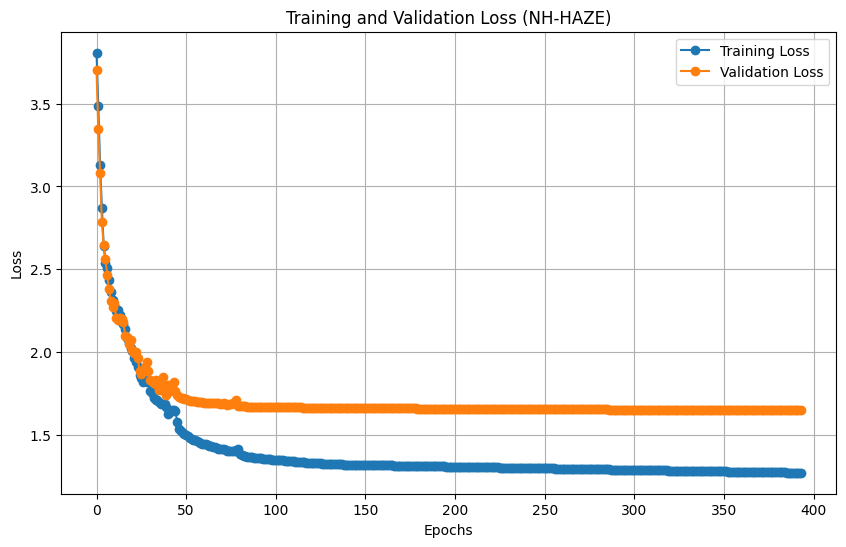

In [4]:
# Plot training and validation loss using Matplotlib
def plot_training_history(history):
    plt.figure(figsize=(10, 6))
    
    # Plot training loss
    plt.plot(history.history['loss'], label='Training Loss', marker='o')
    
    # Plot validation loss
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    
    # Adding title and labels
    plt.title('Training and Validation Loss (NH-HAZE)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='best')
    
    # Show the plot
    plt.grid(True)
    plt.show()

# Display the training history plot
plot_training_history(history)


In [5]:
# Save the enhanced model
model_save_path = 'NH_HAZE_hybrid_unet_rdn_model_with_attention_resnet50_1'
enhanced_model.save(model_save_path)
print(f"Model saved to {model_save_path} in TensorFlow SavedModel format.")

# Load the saved model with custom loss function
loaded_model = load_model(model_save_path, custom_objects={'combined_resnet_loss': combined_resnet_loss})
print("Model loaded successfully.")

INFO:tensorflow:Assets written to: NH_HAZE_hybrid_unet_rdn_model_with_attention_resnet50_1\assets


INFO:tensorflow:Assets written to: NH_HAZE_hybrid_unet_rdn_model_with_attention_resnet50_1\assets


Model saved to NH_HAZE_hybrid_unet_rdn_model_with_attention_resnet50_1 in TensorFlow SavedModel format.
Model loaded successfully.


Evaluating Model:   0%|                                                                          | 0/6 [00:00<?, ?it/s]

1/1 [==============================] - 1s 700ms/step


Evaluating Model:  17%|███████████                                                       | 1/6 [00:02<00:13,  2.78s/it]

1/1 [==============================] - 0s 52ms/step


Evaluating Model:  33%|██████████████████████                                            | 2/6 [00:03<00:07,  1.78s/it]

1/1 [==============================] - 0s 51ms/step


Evaluating Model:  50%|█████████████████████████████████                                 | 3/6 [00:04<00:04,  1.42s/it]

1/1 [==============================] - 0s 53ms/step


Evaluating Model:  67%|████████████████████████████████████████████                      | 4/6 [00:05<00:02,  1.24s/it]

1/1 [==============================] - 0s 47ms/step


Evaluating Model:  83%|███████████████████████████████████████████████████████           | 5/6 [00:06<00:01,  1.16s/it]

1/1 [==============================] - 0s 48ms/step


Evaluating Model: 100%|██████████████████████████████████████████████████████████████████| 6/6 [00:07<00:00,  1.25s/it]


PSNR: 17.7029, SSIM: 0.6384, MSE: 0.019272, CIEDE2000: 11.7419
1/1 [==============================] - 0s 43ms/step


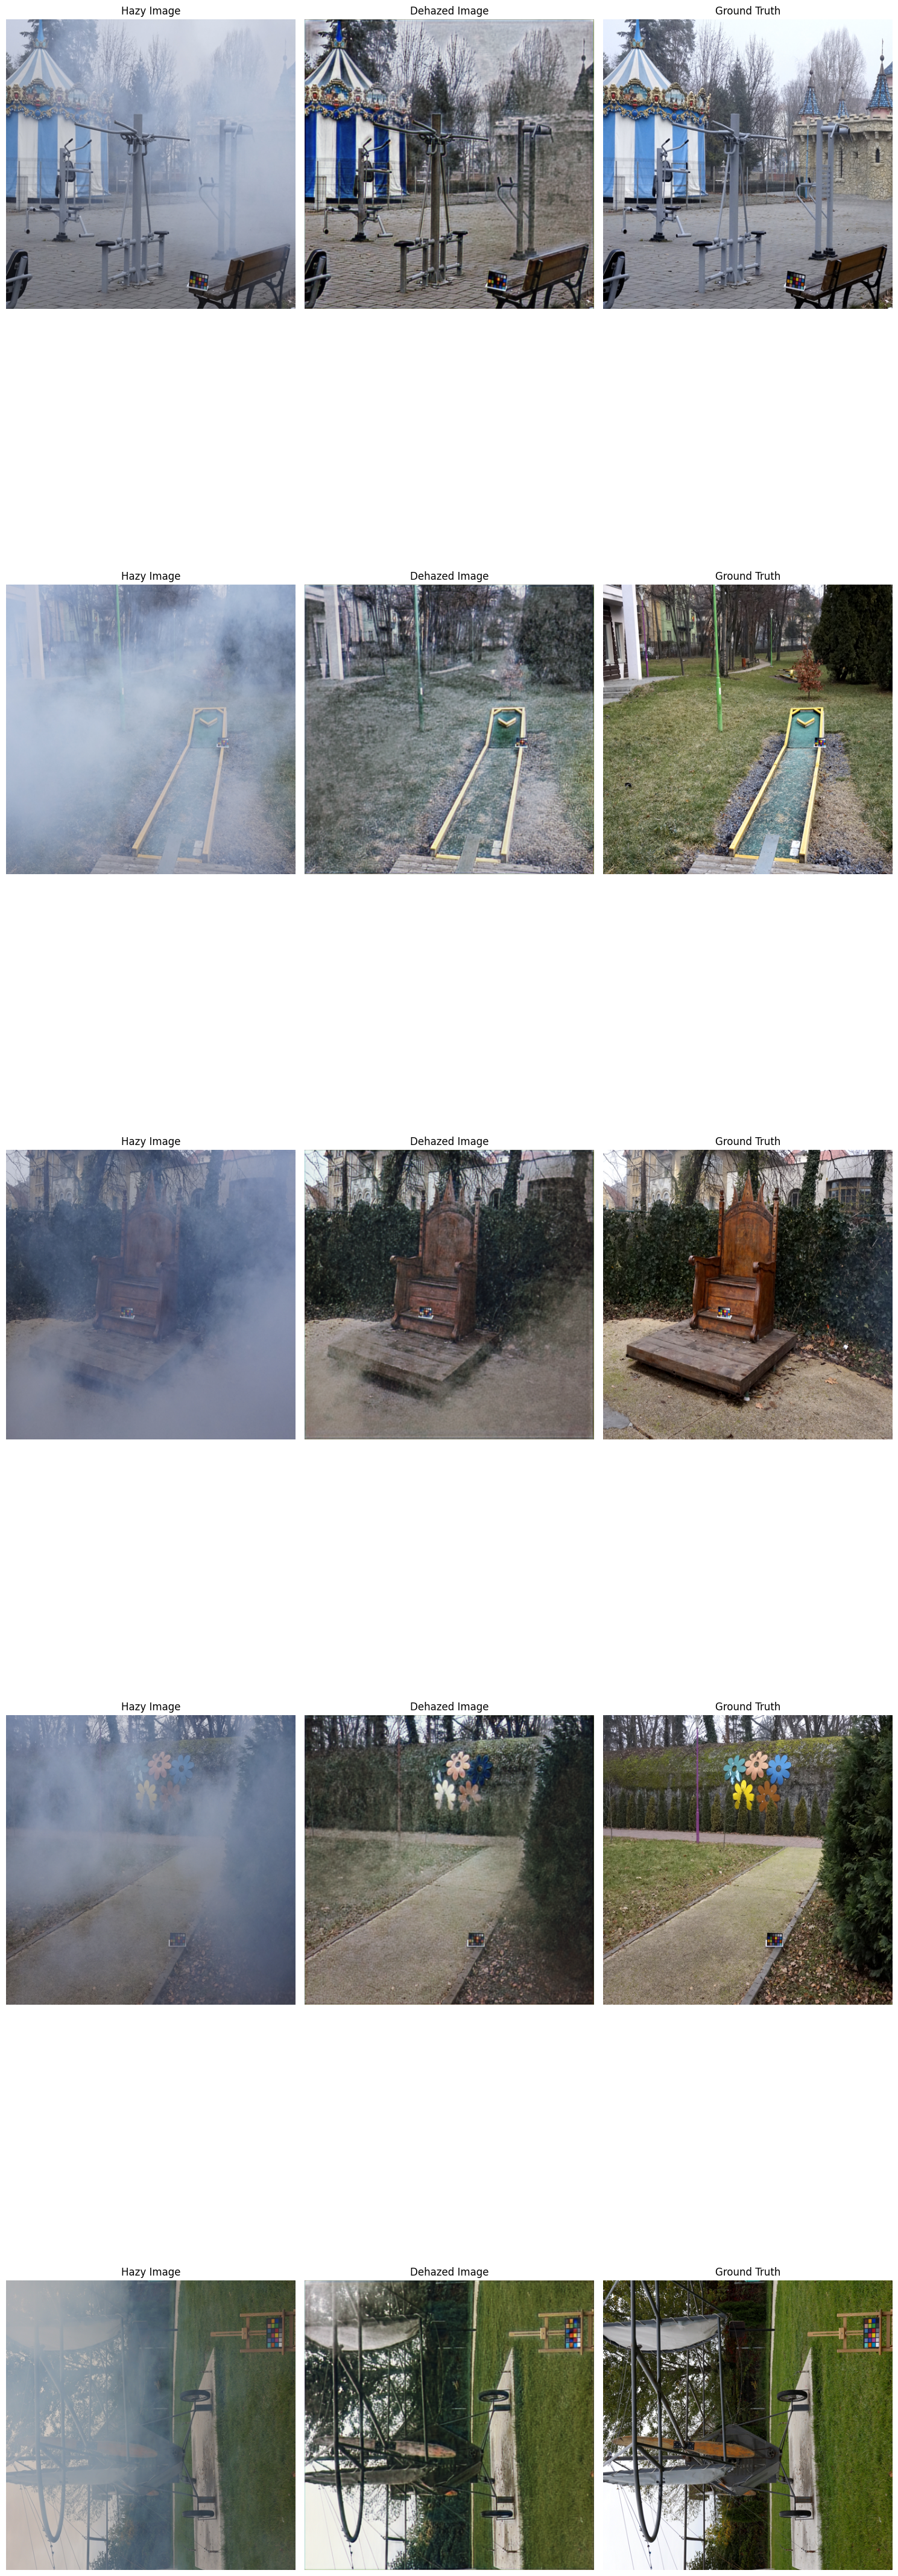

In [6]:
# Function to plot randomly selected dehazed images using Matplotlib
def plot_random_dehazed_images(model, hazy_img_paths, gt_img_paths=None, num_images=5, target_size=(512, 512)):
    selected_indices = random.sample(range(len(hazy_img_paths)), num_images)
    
    plt.figure(figsize=(15, 10 * num_images))
    
    for i, idx in enumerate(selected_indices):
        # Load and preprocess the hazy image
        hazy_img = Image.open(hazy_img_paths[idx])
        hazy_img = hazy_img.resize(target_size)
        hazy_img = np.array(hazy_img) / 255.0
        hazy_input = np.expand_dims(hazy_img, axis=0)
        
        # Predict the dehazed image
        dehazed_img = model.predict(hazy_input)[0]
        
        # Post-process dehazed output to visualize correctly
        dehazed_img = np.clip(dehazed_img, 0, 1)
        
        # Load the ground truth image if available
        gt_img = None
        if gt_img_paths is not None and len(gt_img_paths) > 0:
            gt_img = Image.open(gt_img_paths[idx])
            gt_img = gt_img.resize(target_size)
            gt_img = np.array(gt_img) / 255.0
        
        # Plot the hazy image
        plt.subplot(num_images, 3, 3*i + 1)
        plt.imshow(hazy_img)
        plt.title("Hazy Image")
        plt.axis('off')
        
        # Plot the dehazed image
        plt.subplot(num_images, 3, 3*i + 2)
        plt.imshow(dehazed_img)
        plt.title("Dehazed Image")
        plt.axis('off')
        
        # Plot the ground truth image
        if gt_img is not None:
            plt.subplot(num_images, 3, 3*i + 3)
            plt.imshow(gt_img)
            plt.title("Ground Truth")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Evaluate CIEDE2000 Color Difference
def calculate_ciede2000(image1, image2):
    """Calculate the CIEDE2000 color difference between two images."""
    lab1 = color.rgb2lab(image1)
    lab2 = color.rgb2lab(image2)
    ciede2000 = color.deltaE_ciede2000(lab1, lab2)
    return np.mean(ciede2000)

# Evaluate the model
def evaluate_model(model, dataset, win_size=5):
    psnr_values = []
    ssim_values = []
    mse_values = []
    ciede2000_values = []
    
    for X_batch, y_batch in tqdm(dataset, desc="Evaluating Model"):
        y_pred = model.predict(X_batch)
        for true, pred in zip(y_batch, y_pred):
            if isinstance(true, tf.Tensor):
                true = true.numpy()
            if isinstance(pred, tf.Tensor):
                pred = pred.numpy()
            
            true = true.astype(np.float32)
            pred = pred.astype(np.float32)
            
            psnr = tf.image.psnr(true, pred, max_val=1.0).numpy()
            psnr_values.append(psnr)
            
            ssim_index = ssim(true, pred, channel_axis=-1, data_range=1.0, win_size=win_size)
            ssim_values.append(ssim_index)
            
            mse = np.mean((true - pred) ** 2)
            mse_values.append(mse)
            
            ciede2000 = calculate_ciede2000(true, pred)
            ciede2000_values.append(ciede2000)
    
    return (
        np.mean(psnr_values), 
        np.mean(ssim_values), 
        np.mean(mse_values), 
        np.mean(ciede2000_values)
    )

# Evaluate model
psnr, ssim_index, mse, ciede2000 = evaluate_model(loaded_model, val_dataset, win_size=5)
print(f"PSNR: {psnr:.4f}, SSIM: {ssim_index:.4f}, MSE: {mse:.6f}, CIEDE2000: {ciede2000:.4f}")

# Plot the randomly selected dehazed images
plot_random_dehazed_images(loaded_model, hazy_paths, clear_paths, num_images=5)
